In [3]:
# Import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error
import shap

pd.set_option('future.no_silent_downcasting', True)


## Loading data & preprocessing

In [4]:
# load data

data = pd.read_csv("data/WorldDevelopmentIndicatorsCountries/data.csv")
print(data.columns)



Index(['Country Name', 'Country Code', 'Series Name', 'Series Code',
       '2023 [YR2023]'],
      dtype='object')


#### Bring the dataset into shape by having each feature represent a column 

In [5]:
# rename features
data.columns = ["country", "country_code", "var", "var_code", "score"]

# Pivot data such that each series is a column 
data = data[data.duplicated(keep=False) == False] # remove duplicated rows (All NaN rows)

data_piv = data.pivot(index= "country", columns="var", values = "score")
data_piv = data_piv.replace("..", np.nan) # reformat missing entries to nan


### Missing value removal 

As we have many columns with a high proportion of missings, we first remove all of columns with significant missings. Afterwards we procede with complete-case analyses. 

In [6]:
# remove missing values
threshold = 0.1
missing_ratio = data_piv.isnull().mean()

# Drop columns with more than 20% missing values
df = data_piv.loc[:, missing_ratio <= threshold]

# remove entries with missings
df = df.dropna()

df.head()

var,Age dependency ratio (% of working-age population),"Age dependency ratio, old (% of working-age population)","Age dependency ratio, young (% of working-age population)","Compulsory education, duration (years)",GDP (constant 2015 US$),GDP (current US$),GDP growth (annual %),GDP per capita (constant 2015 US$),GDP per capita (current US$),GDP per capita growth (annual %),...,"Preprimary education, duration (years)","Primary education, duration (years)",Rural population,Rural population (% of total population),Rural population growth (annual %),"Secondary education, duration (years)",Secure Internet servers (per 1 million people),Urban population,Urban population (% of total population),Urban population growth (annual %)
country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,83.8361728436287,4.37077621707188,79.4653966265569,9,15740683549.2312,17233051620.1117,2.71088679128353,379.707497269884,415.707417059086,0.540655554216826,...,1,6,30289750,73.067,1.70268453495611,6,43.758544404586,11165011,26.933,3.31956817544451
Africa Eastern and Southern,79.1468573052485,5.85353173419715,72.2568314141834,7.5,1064487323079.33,1245472471675.95,2.32013780158924,1418.3637366532,1659.51529015376,-0.226928404970664,...,3,6,462123459,61.5751019469744,1.70079440903869,6,1307.52708656635,288380305,38.4248980530256,3.94845245021705
Africa Western and Central,81.1022875892634,5.35486931780497,75.4155134420043,9,927489896195.979,799105950273.831,3.3547328190002,1820.75474142308,1568.72431045118,0.917670772142557,...,3,6,256170520,50.2888158752654,1.2444397284699,7,37.7994765117027,253228069,49.7111841247346,3.62682536302485
Albania,50.0239297710391,24.4568816121017,25.5670481589374,9,14882173624.9218,23547179830.4413,3.93662525742167,5419.63779125273,8575.17113446213,5.13713201542561,...,5,5,971992,35.397,-3.39433549868561,7,1220.33290943972,1773980,64.603,0.103888261229259
Algeria,58.7709984775404,10.1246021758787,48.6463963016617,10,215143978139.689,247626161016.414,4.10000000000004,4660.40545686886,5364.02795022731,2.55120301937745,...,1,5,11417335,24.732,-0.486677214117599,7,100.294126063305,34746884,75.268,2.16013530926815


### Inclusion criteria 

As countries represent rows, we need to remove aggregates from the list such as the EU in order to ensure that each entry provides unique information and is not represented multiple times. 

From the feature set we removed features that counted the percentage of population within a certain age frame. Instead we used the age-dependency ratios for young and old

In [7]:
# only keep countries, remove aggregates such as the EU
df = df.drop(["Africa Eastern and Southern", "Africa Western and Central", "Arab World", "Central Europe and the Baltics",
                      "Early-demographic dividend", "East Asia & Pacific", "East Asia & Pacific (IDA & IBRD countries)", 
                      "East Asia & Pacific (excluding high income)", "Euro area", "Europe & Central Asia", "Europe & Central Asia (IDA & IBRD countries)", 
                      "Europe & Central Asia (excluding high income)", "European Union", "Fragile and conflict affected situations", "Heavily indebted poor countries (HIPC)", 
                      "High income", "IBRD only", "IDA & IBRD total", "IDA blend", "IDA only", "IDA total", "Lao PDR", "Late-demographic dividend", 
                      "Latin America & Caribbean", "Latin America & Caribbean (excluding high income)", "Latin America & the Caribbean (IDA & IBRD countries)", 
                      "Least developed countries: UN classification", "Low & middle income", "Low income", "Lower middle income", "Middle East & North Africa", 
                      "Middle East & North Africa (IDA & IBRD countries)", "Middle East & North Africa (excluding high income)", "Middle income",
                      "North America", "OECD members", "Other small states", "Post-demographic dividend", "Pre-demographic dividend", "Small states", 
                      "South Asia", "South Asia (IDA & IBRD)","Sub-Saharan Africa", "Sub-Saharan Africa (IDA & IBRD countries)", "Sub-Saharan Africa (excluding high income)", 
                      "Upper middle income", "World" ])

In [8]:
# Check data types and correct
dftypes= df.dtypes
df = df.map(lambda x: pd.to_numeric(x, errors='coerce'))


# select features 
features = ["Age dependency ratio, old (% of working-age population)", "Age dependency ratio, young (% of working-age population)",
              "Compulsory education, duration (years)", "Merchandise trade (% of GDP)", "Net migration", "Preprimary education, duration (years)",
              "Primary education, duration (years)", "Urban population (% of total population)", "Rural population growth (annual %)",
              "Secondary education, duration (years)", "Secure Internet servers (per 1 million people)","Urban population growth (annual %)",
              "GDP per capita growth (annual %)"]

data = df[features]
countries = pd.DataFrame(df.index)

### Investigate data structure

plotting the correlation matrix and histograms to get a better idea of the relations and data structure

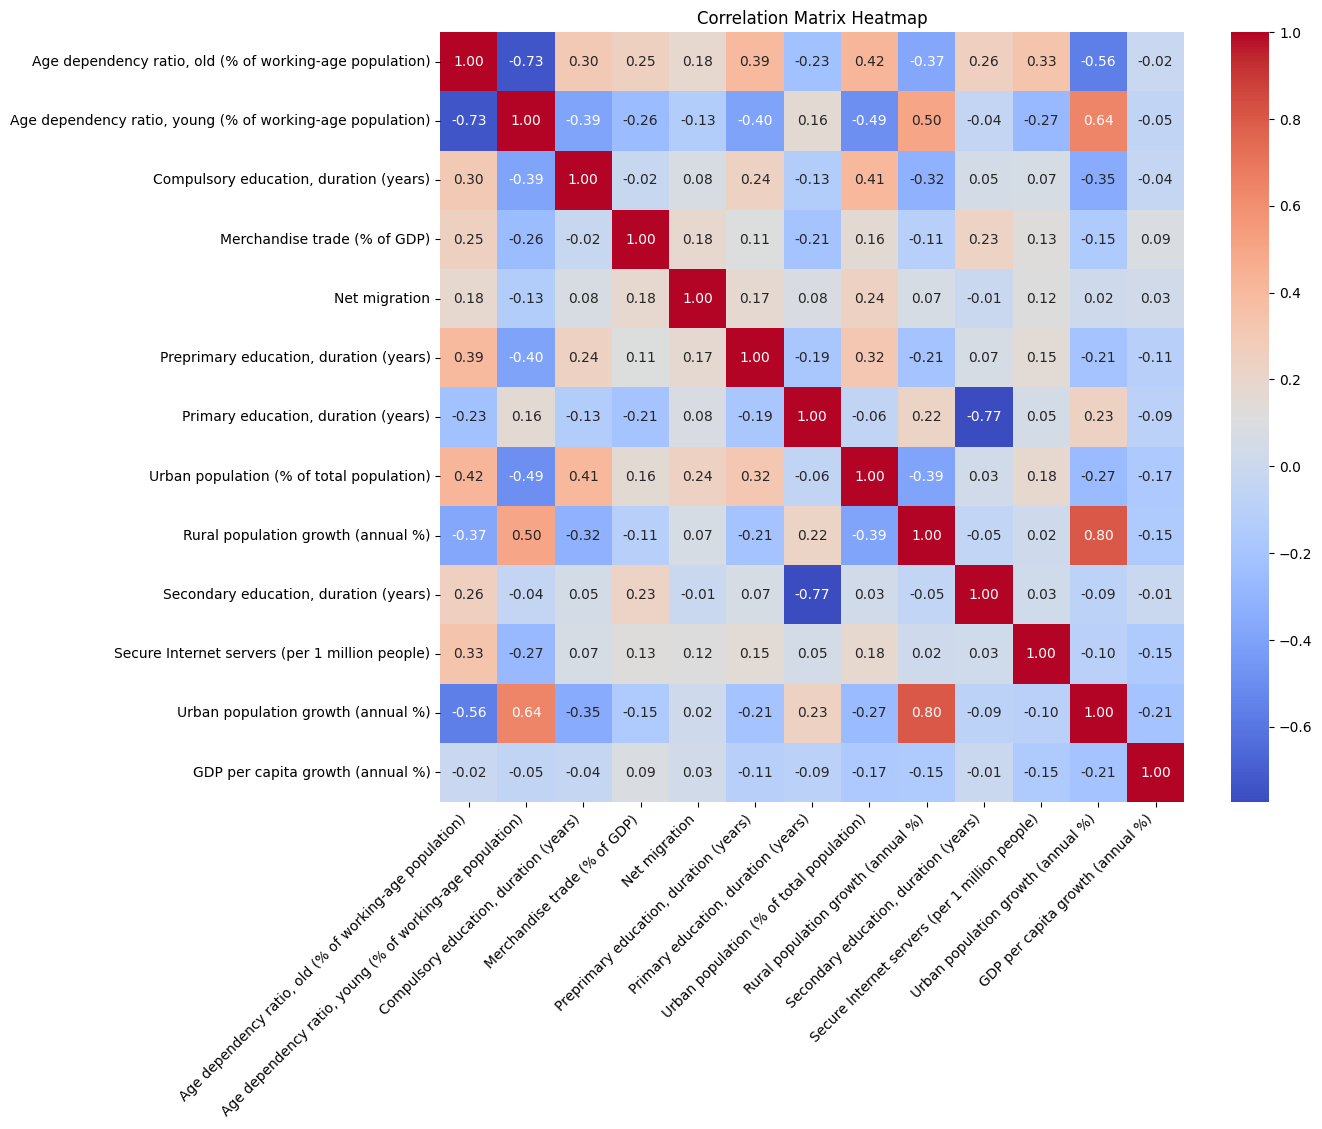

In [9]:
# Correlation matrix
corr = data.corr()
corr_names = pd.Series(data.columns)

# Plotting the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix Heatmap")
plt.xticks(ticks=np.arange(len(corr_names)) + 0.5, labels=corr_names, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(corr_names)) + 0.5, labels=corr_names, rotation=0)
plt.xlabel("")
plt.ylabel("")
plt.savefig('img/featureHeatmap.png', dpi=300, bbox_inches='tight')
plt.show()

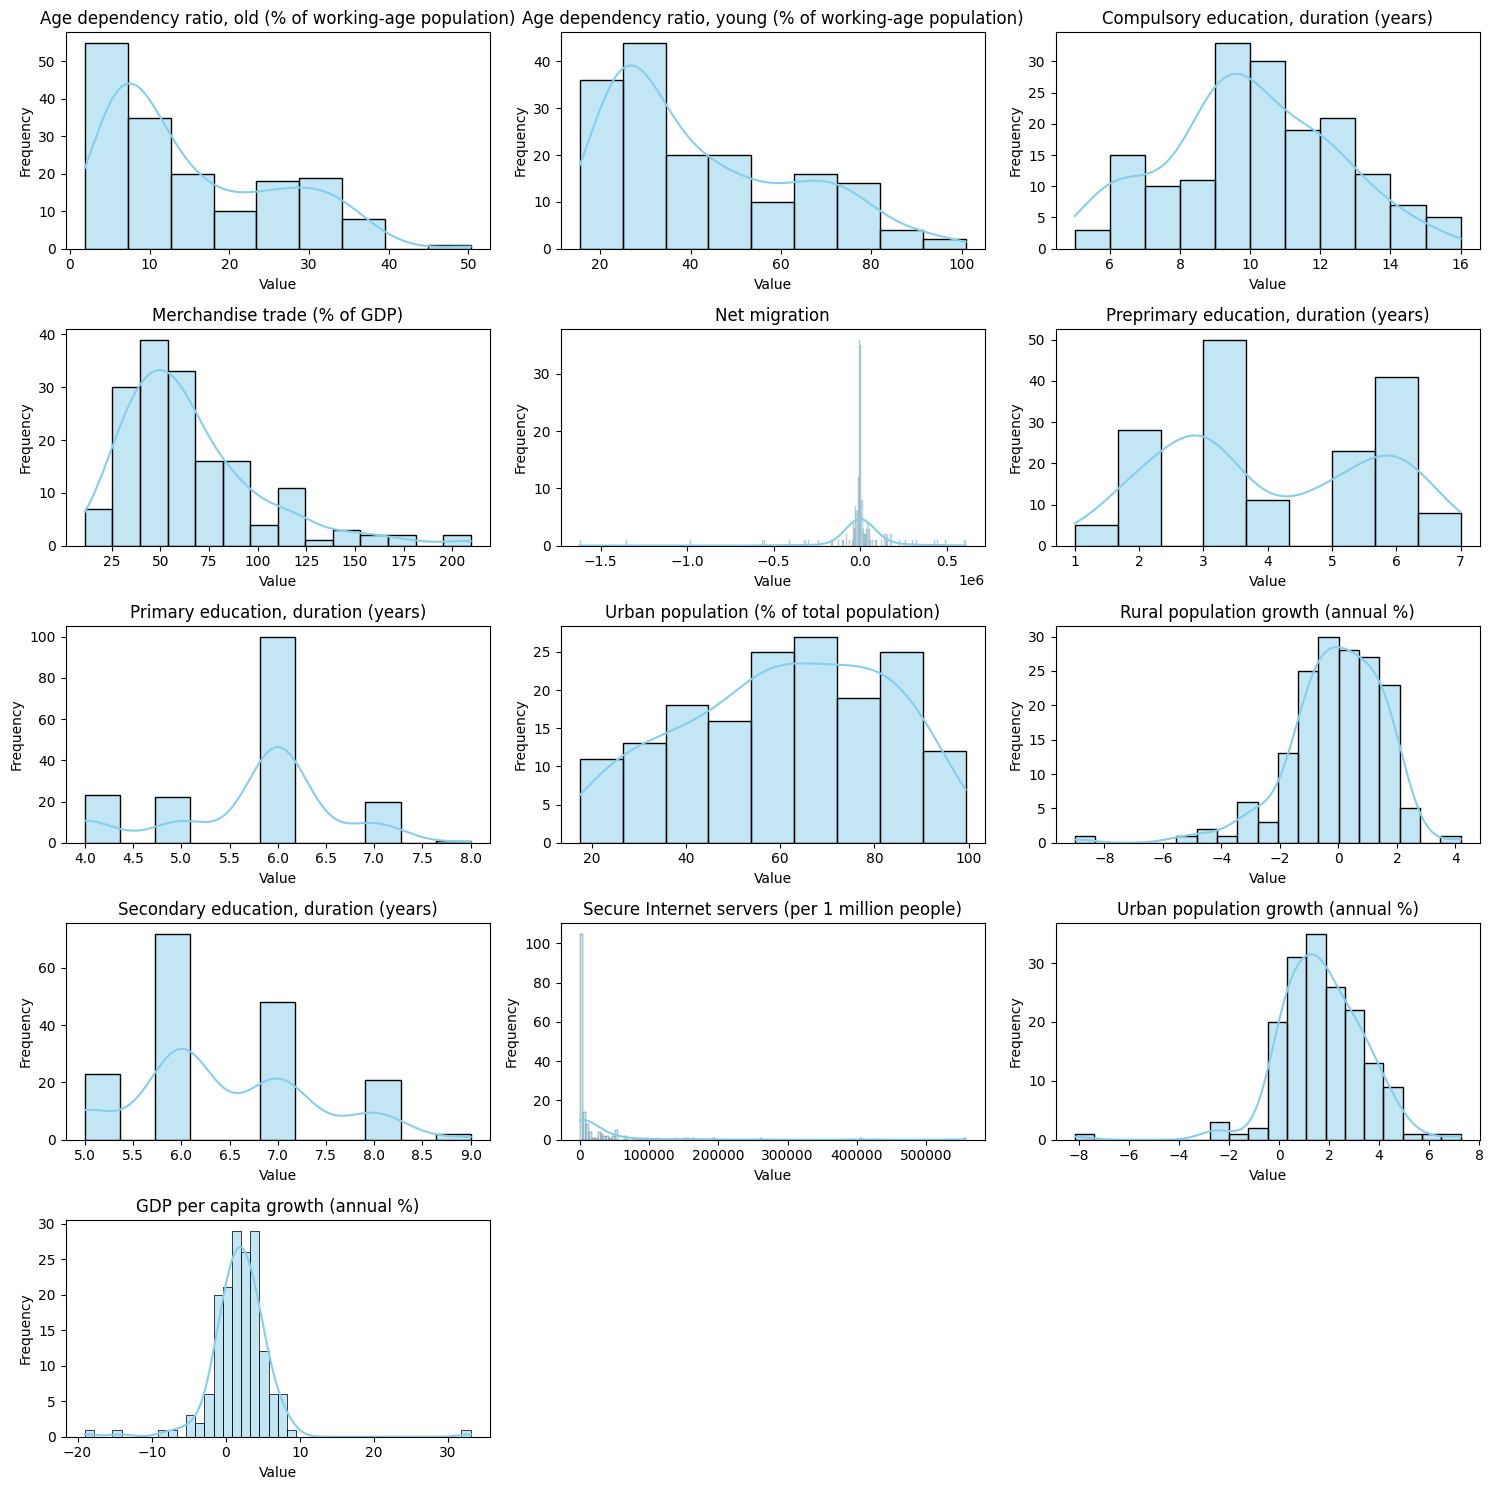

In [10]:
# Histograms

fig, axs = plt.subplots(5, 3, figsize=(15, 15))
axs = axs.flatten()

# Plot each column
for i, column in enumerate(data.columns):
    sns.histplot(data=df, x=column, kde=True, color="skyblue", ax=axs[i])
    axs[i].set_title(f"{column}")
    axs[i].set_xlabel("Value")
    axs[i].set_ylabel("Frequency")

# remove empty subplot
for j in range(len(data.columns), len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.savefig('img/featureHistograms.png', dpi=300, bbox_inches='tight')
plt.show()


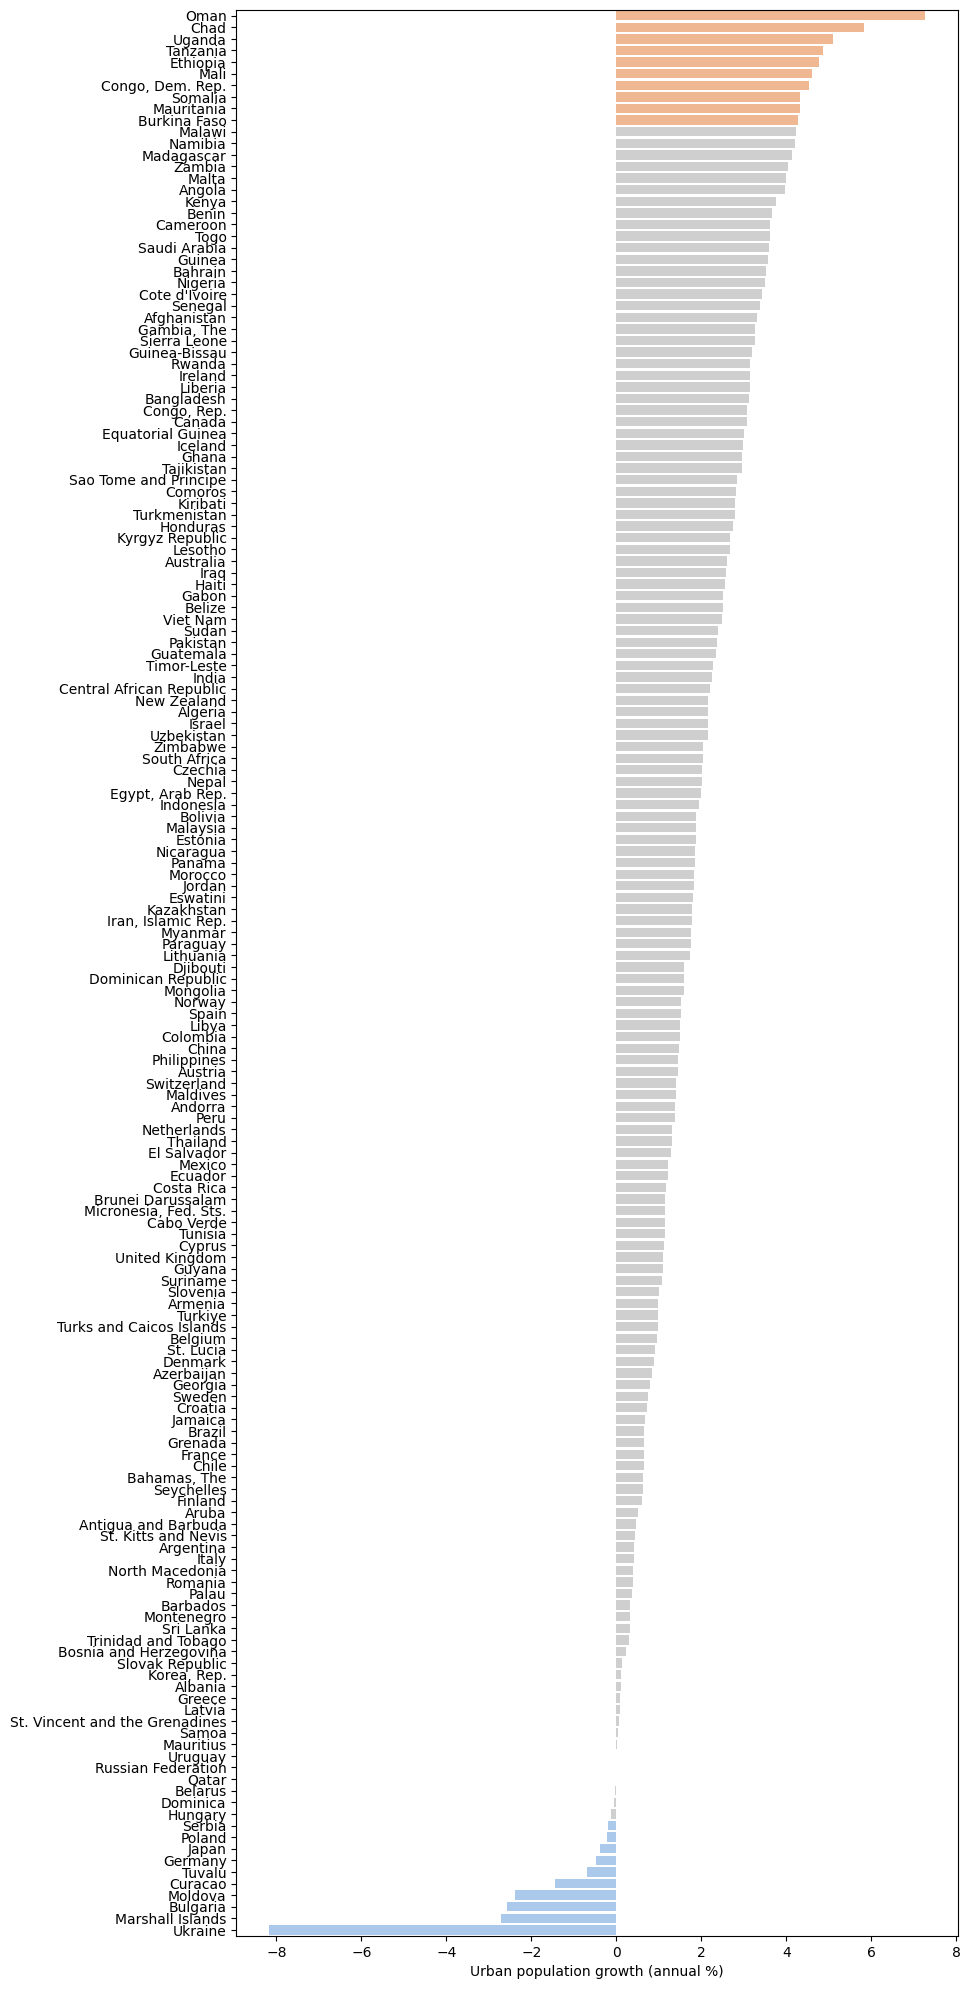

Mean urban population growth 1.72 %


In [11]:
# Urban population growth by country

data = data.reset_index(drop=True)
countries = countries.reset_index(drop=True)

urbanGrowthCountry = pd.DataFrame({
    "urbanGrowth": data["Urban population growth (annual %)"],
    "country": countries["country"]
})

pal = ["#FFB482","#CFCFCF","#A1C9F4"]
urbanGrowthCountry = urbanGrowthCountry.sort_values(by="urbanGrowth", ascending=False)
urbanGrowthCountry = urbanGrowthCountry.reset_index(drop=True)
urbanGrowthCountry["group"] = pd.Series(["high"]*10 + ["medium"]*146 +["low"]*10 )


plt.figure(figsize=(10, 20))
sns.barplot(urbanGrowthCountry, x="urbanGrowth", y="country", hue="group", palette=pal, legend = None)
plt.tight_layout()
plt.ylabel("")
plt.xlabel("Urban population growth (annual %)")
plt.savefig("img/urbanGrowthCountry.png", dpi=300, bbox_inches='tight')
plt.show()

print("Mean urban population growth {:.2f} %".format(urbanGrowthCountry["urbanGrowth"].mean()))

## Model training

Derive train/test and validation sets & initialize hyperparameter training

In [13]:
# Make feature and target set
y = data["Urban population growth (annual %)"]
X = data.drop(columns=["Urban population growth (annual %)"])


# Make train-val-test split
X_train, X_test, y_train, y_test, c_train, c_test = train_test_split(X, y, countries,  test_size=0.2, random_state=2)

X_train, X_val,  y_train, y_val, c_train, c_val  = train_test_split(X_train, y_train, c_train, test_size=0.25, random_state=2)


In [14]:
# hyperparameters for model training
hyperparam_grid = {
    'n_estimators' : [500, 1000, 1500],
    'max_depth' : [3, 4, 5, 6, 7],
    'max_features' : [3, 4, 5, 6]
}

In [15]:
# initialize grid search
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=22),
                           param_grid=hyperparam_grid, cv=KFold(n_splits=10, shuffle=True, random_state=22))

# Perform grid search
grid_search.fit(X_train, y_train)

# save model
with open('data/grid_search_results.pkl', 'wb') as f:
    pickle.dump(grid_search, f)

In [16]:
# PLOT GRID SEARCH RESULT & BASELINE PERFORMANCE
results = pd.DataFrame(grid_search.cv_results_)

val_scores = []
train_error = []
val_error = []
performance = []

### Plot the training results 

In [17]:
# Check model train, val, and overfitting performance
for i in range(len(results)):
    params = results['params'][i]

    model = RandomForestRegressor(**params, random_state=22)
    model.fit(X_train, y_train)

    # train and validation error
    train_error.append(root_mean_squared_error(y_train, model.predict(X_train)))
    val_error.append(root_mean_squared_error(y_val, model.predict(X_val)))

    # check overfitting of model
    performance.append(val_error[i]-train_error[i])


# SELECT MODEL WITH LOWEST PREDICTION FOR VAL SET & LEAST overfitting
perf_results = pd.DataFrame({
    'performance': performance,
    'val_error': val_error,
    'train_error': train_error,
    'max_depth': results['param_max_depth'],
    'max_features': results['param_max_features'],
    'n_estimators': results['param_n_estimators']
})


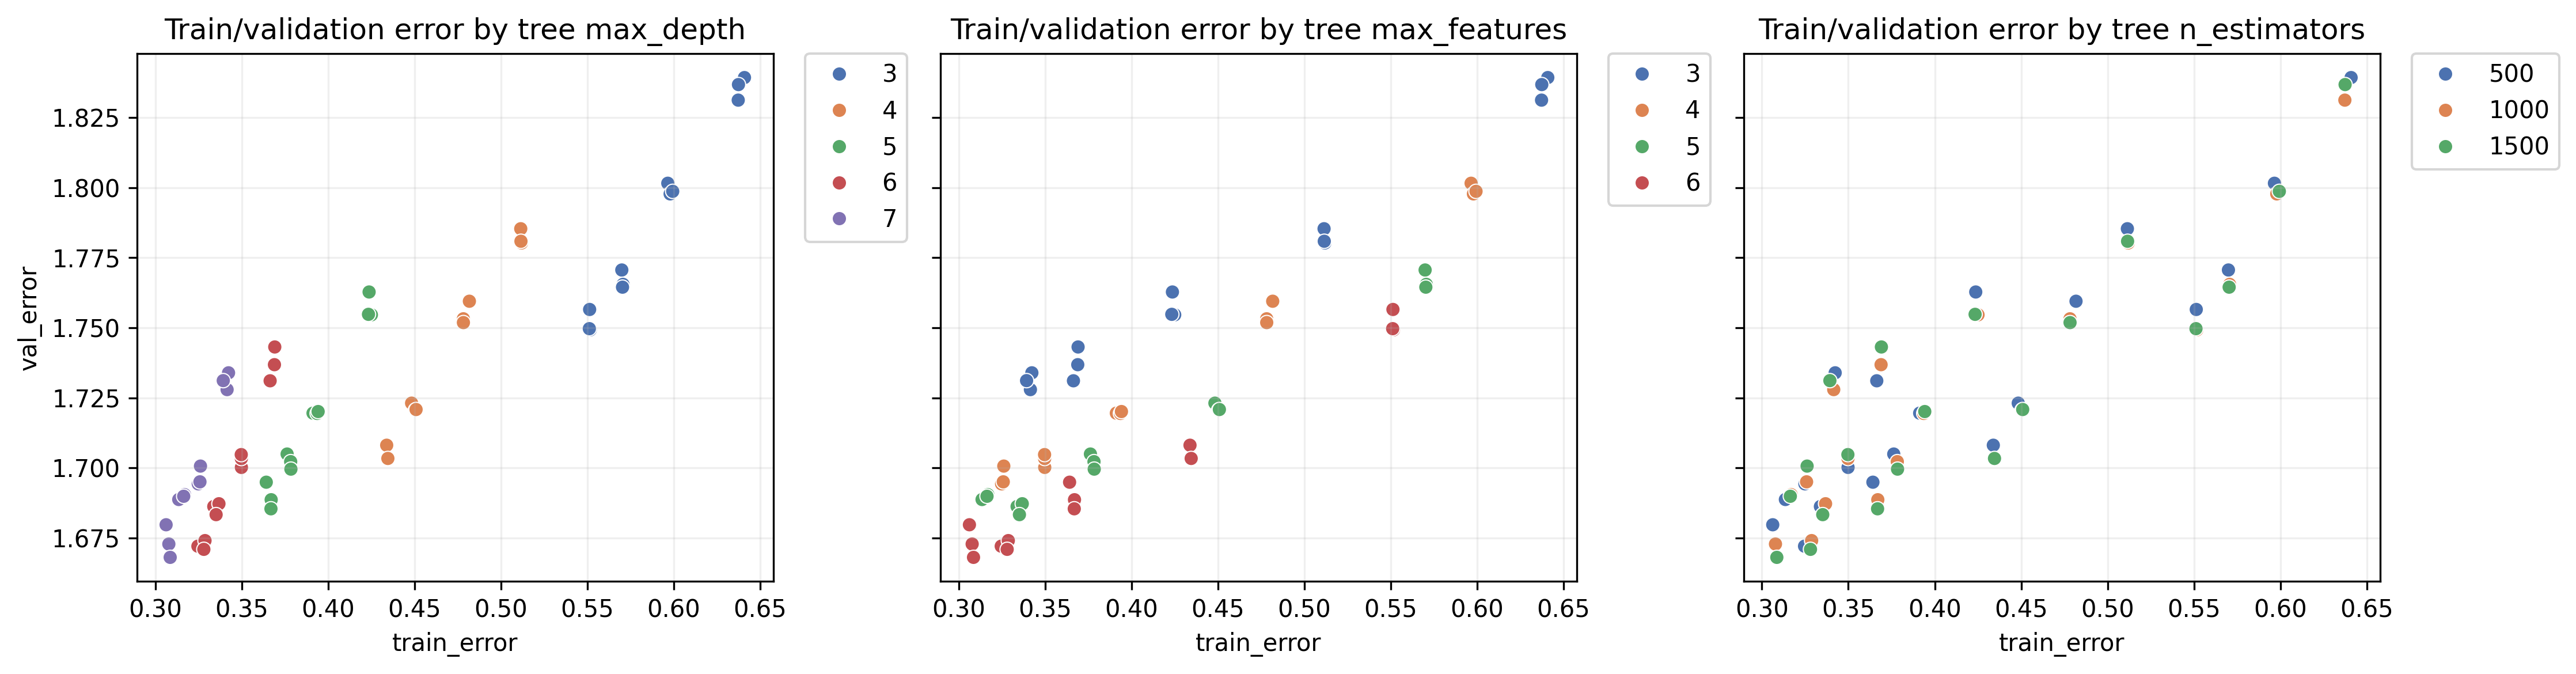

In [18]:
# Train vs. Validation error by RF parameters
fig, axs = plt.subplots(ncols=3, sharey=True, figsize=(15, 4), dpi=300)
sns.scatterplot(data=perf_results, x="train_error", y="val_error", hue="max_depth", palette="deep", ax=axs[0])
axs[0].grid(alpha=0.2)
axs[0].set_title("Train/validation error by tree max_depth")

sns.scatterplot(data=perf_results, x="train_error", y="val_error", hue="max_features", palette="deep", ax=axs[1])
axs[1].grid(alpha=0.2)
axs[1].set_title("Train/validation error by tree max_features")

sns.scatterplot(data=perf_results, x="train_error", y="val_error", hue="n_estimators", palette="deep", ax=axs[2])
axs[2].grid(alpha=0.2)
axs[2].set_title("Train/validation error by tree n_estimators")

for ax in axs:
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.savefig('img/performance_trainVal.png')
plt.show()

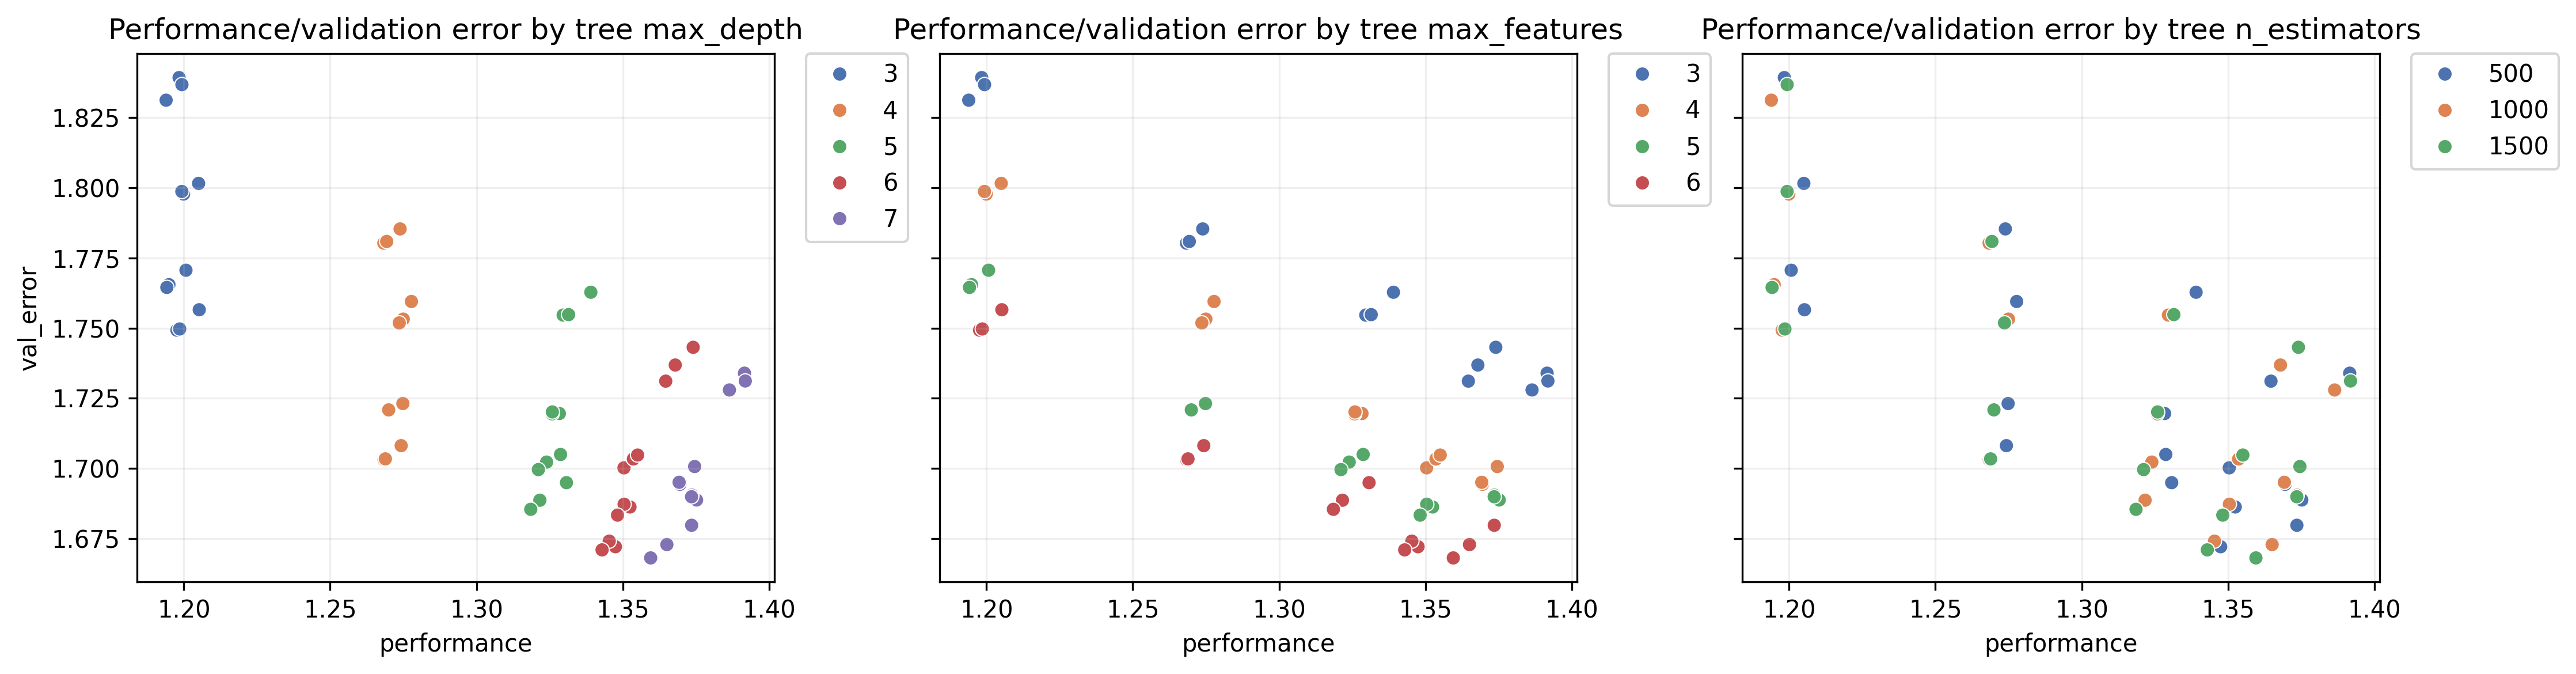

In [19]:
# Validation-Train vs. Validation error by RF parameters
fig, axs = plt.subplots(ncols=3, sharey=True, figsize=(15, 4), dpi=300)
sns.scatterplot(data=perf_results, x="performance", y="val_error", hue="max_depth", palette="deep", ax=axs[0])
axs[0].grid(alpha=0.2)
axs[0].set_title("Performance/validation error by tree max_depth")

sns.scatterplot(data=perf_results, x="performance", y="val_error", hue="max_features", palette="deep", ax=axs[1])
axs[1].grid(alpha=0.2)
axs[1].set_title("Performance/validation error by tree max_features")

sns.scatterplot(data=perf_results, x="performance", y="val_error", hue="n_estimators", palette="deep", ax=axs[2])
axs[2].grid(alpha=0.2)
axs[2].set_title("Performance/validation error by tree n_estimators")

for ax in axs:
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.savefig('img/performance_performanceVal.png')
plt.show()

### Select optimal model performance by selecting the lowest validation error and lowest performance error 

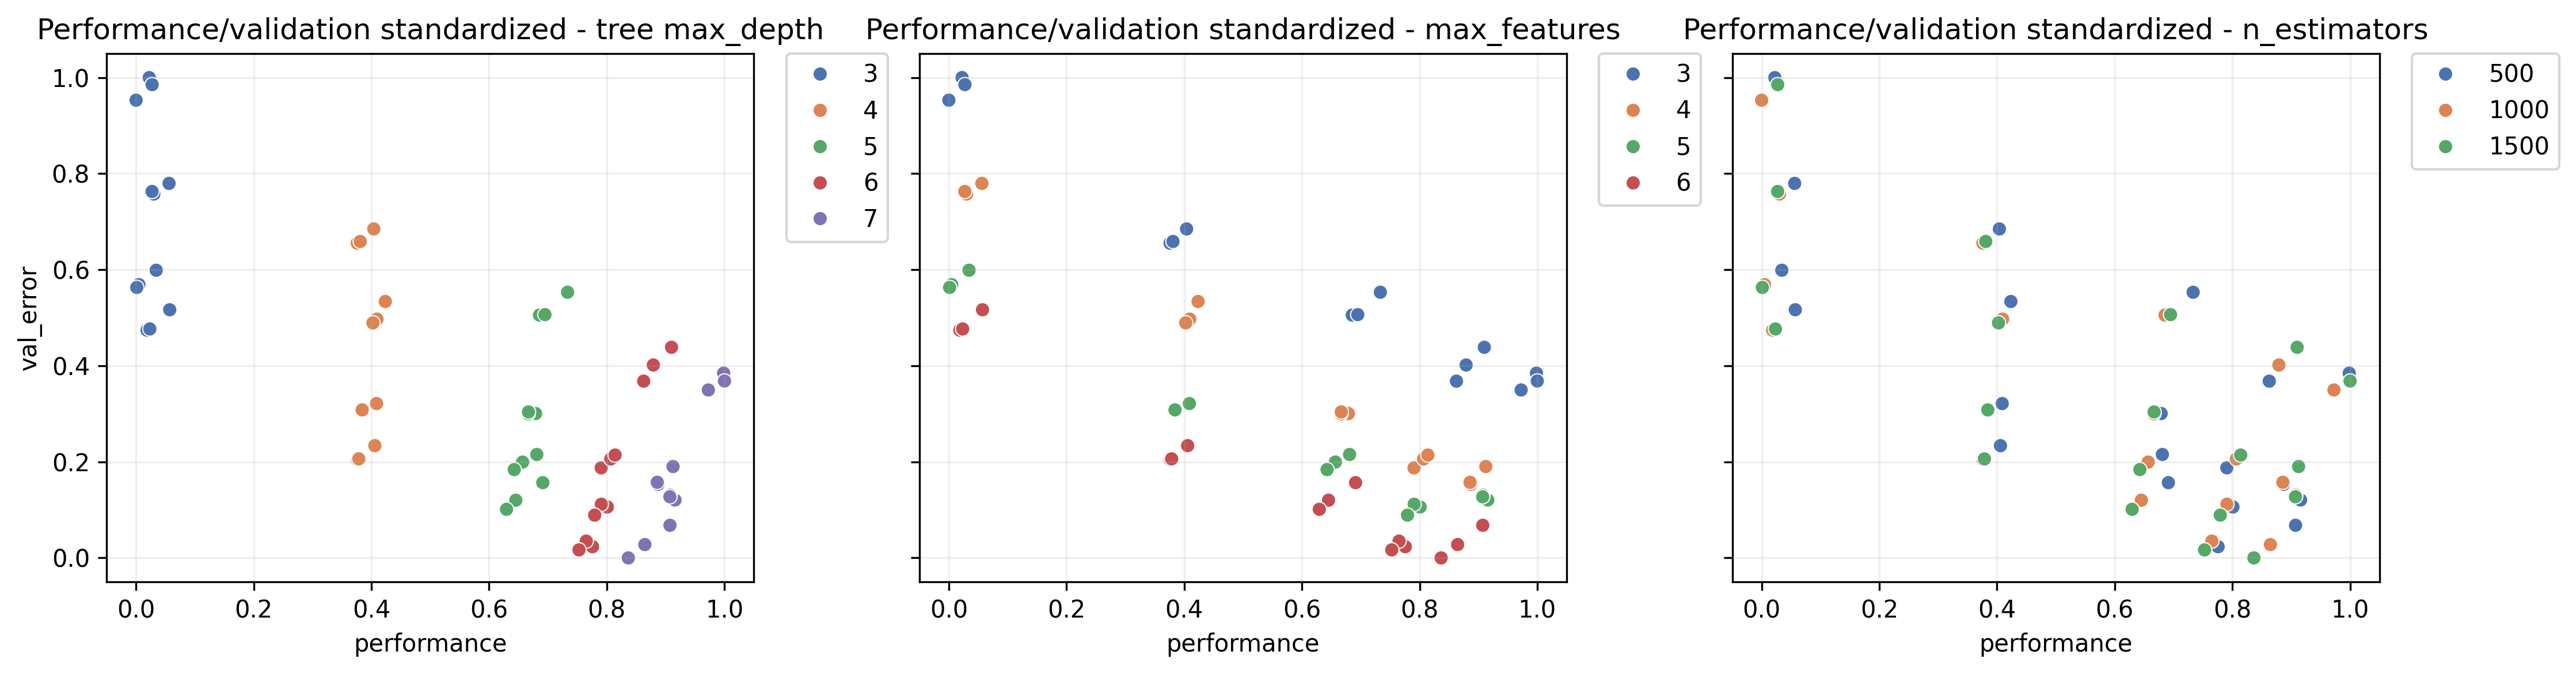

In [20]:
# define standard scaler
scaler = MinMaxScaler()

# standardize scores to select best model
results_standardized = pd.DataFrame(scaler.fit_transform(perf_results[["performance", "val_error", "train_error"]]))
results_standardized["max_depth"] = results["param_max_depth"]
results_standardized["max_features"] = results["param_max_features"]
results_standardized["n_estimators"] = results["param_n_estimators"]

results_standardized.columns = ["performance","val_error", "train_error", "max_depth", "max_features", "n_estimators"]

fig, axs = plt.subplots(ncols=3, sharey=True, figsize=(15, 4), dpi=300)
sns.scatterplot(data=results_standardized, x="performance", y="val_error", hue="max_depth", palette="deep", ax=axs[0])
axs[0].grid(alpha=0.2)
axs[0].set_title("Performance/validation standardized - tree max_depth")

sns.scatterplot(data=results_standardized, x="performance", y="val_error", hue="max_features", palette="deep", ax=axs[1])
axs[1].grid(alpha=0.2)
axs[1].set_title("Performance/validation standardized - max_features")

sns.scatterplot(data=results_standardized, x="performance", y="val_error", hue="n_estimators", palette="deep", ax=axs[2])
axs[2].grid(alpha=0.2)
axs[2].set_title("Performance/validation standardized - n_estimators")

for ax in axs:
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.savefig('img/standardized_performanceVal.png')
plt.show()

results_standardized["sum"] = results_standardized["performance"] + results_standardized["val_error"]
ind = np.argmin(results_standardized["sum"])
selected_model = results_standardized.iloc[ind]

### Build final model with trained parameters 

In [21]:
# Make final model
final_model = RandomForestRegressor(max_depth=selected_model["max_depth"].astype(int),
                                    max_features=selected_model["max_features"].astype(int),
                                    n_estimators=selected_model["n_estimators"].astype(int),
                                    random_state=22)
final_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=np.int64(3), max_features=np.int64(6),
                      n_estimators=np.int64(1000), random_state=22)

## How accurately can we predict urban population growth across different countries?
### Make predictions for train, validation and test set

In [22]:
# PREDICT TEST SET
final_results = pd.DataFrame({
    "Train_rmse": [root_mean_squared_error(y_train, final_model.predict(X_train))],
    "Val_rmse" : [root_mean_squared_error(y_val, final_model.predict(X_val))],
    "Test_rmse" : [root_mean_squared_error(y_test, final_model.predict(X_test))]
})

print(final_results)

   Train_rmse  Val_rmse  Test_rmse
0    0.551648  1.749271    1.09706


### Show test set predictions

/var/folders/wv/2by9xqwj4055k_j2_d5fy0kr0000gn/T/ipykernel_6421/4180533239.py:42: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


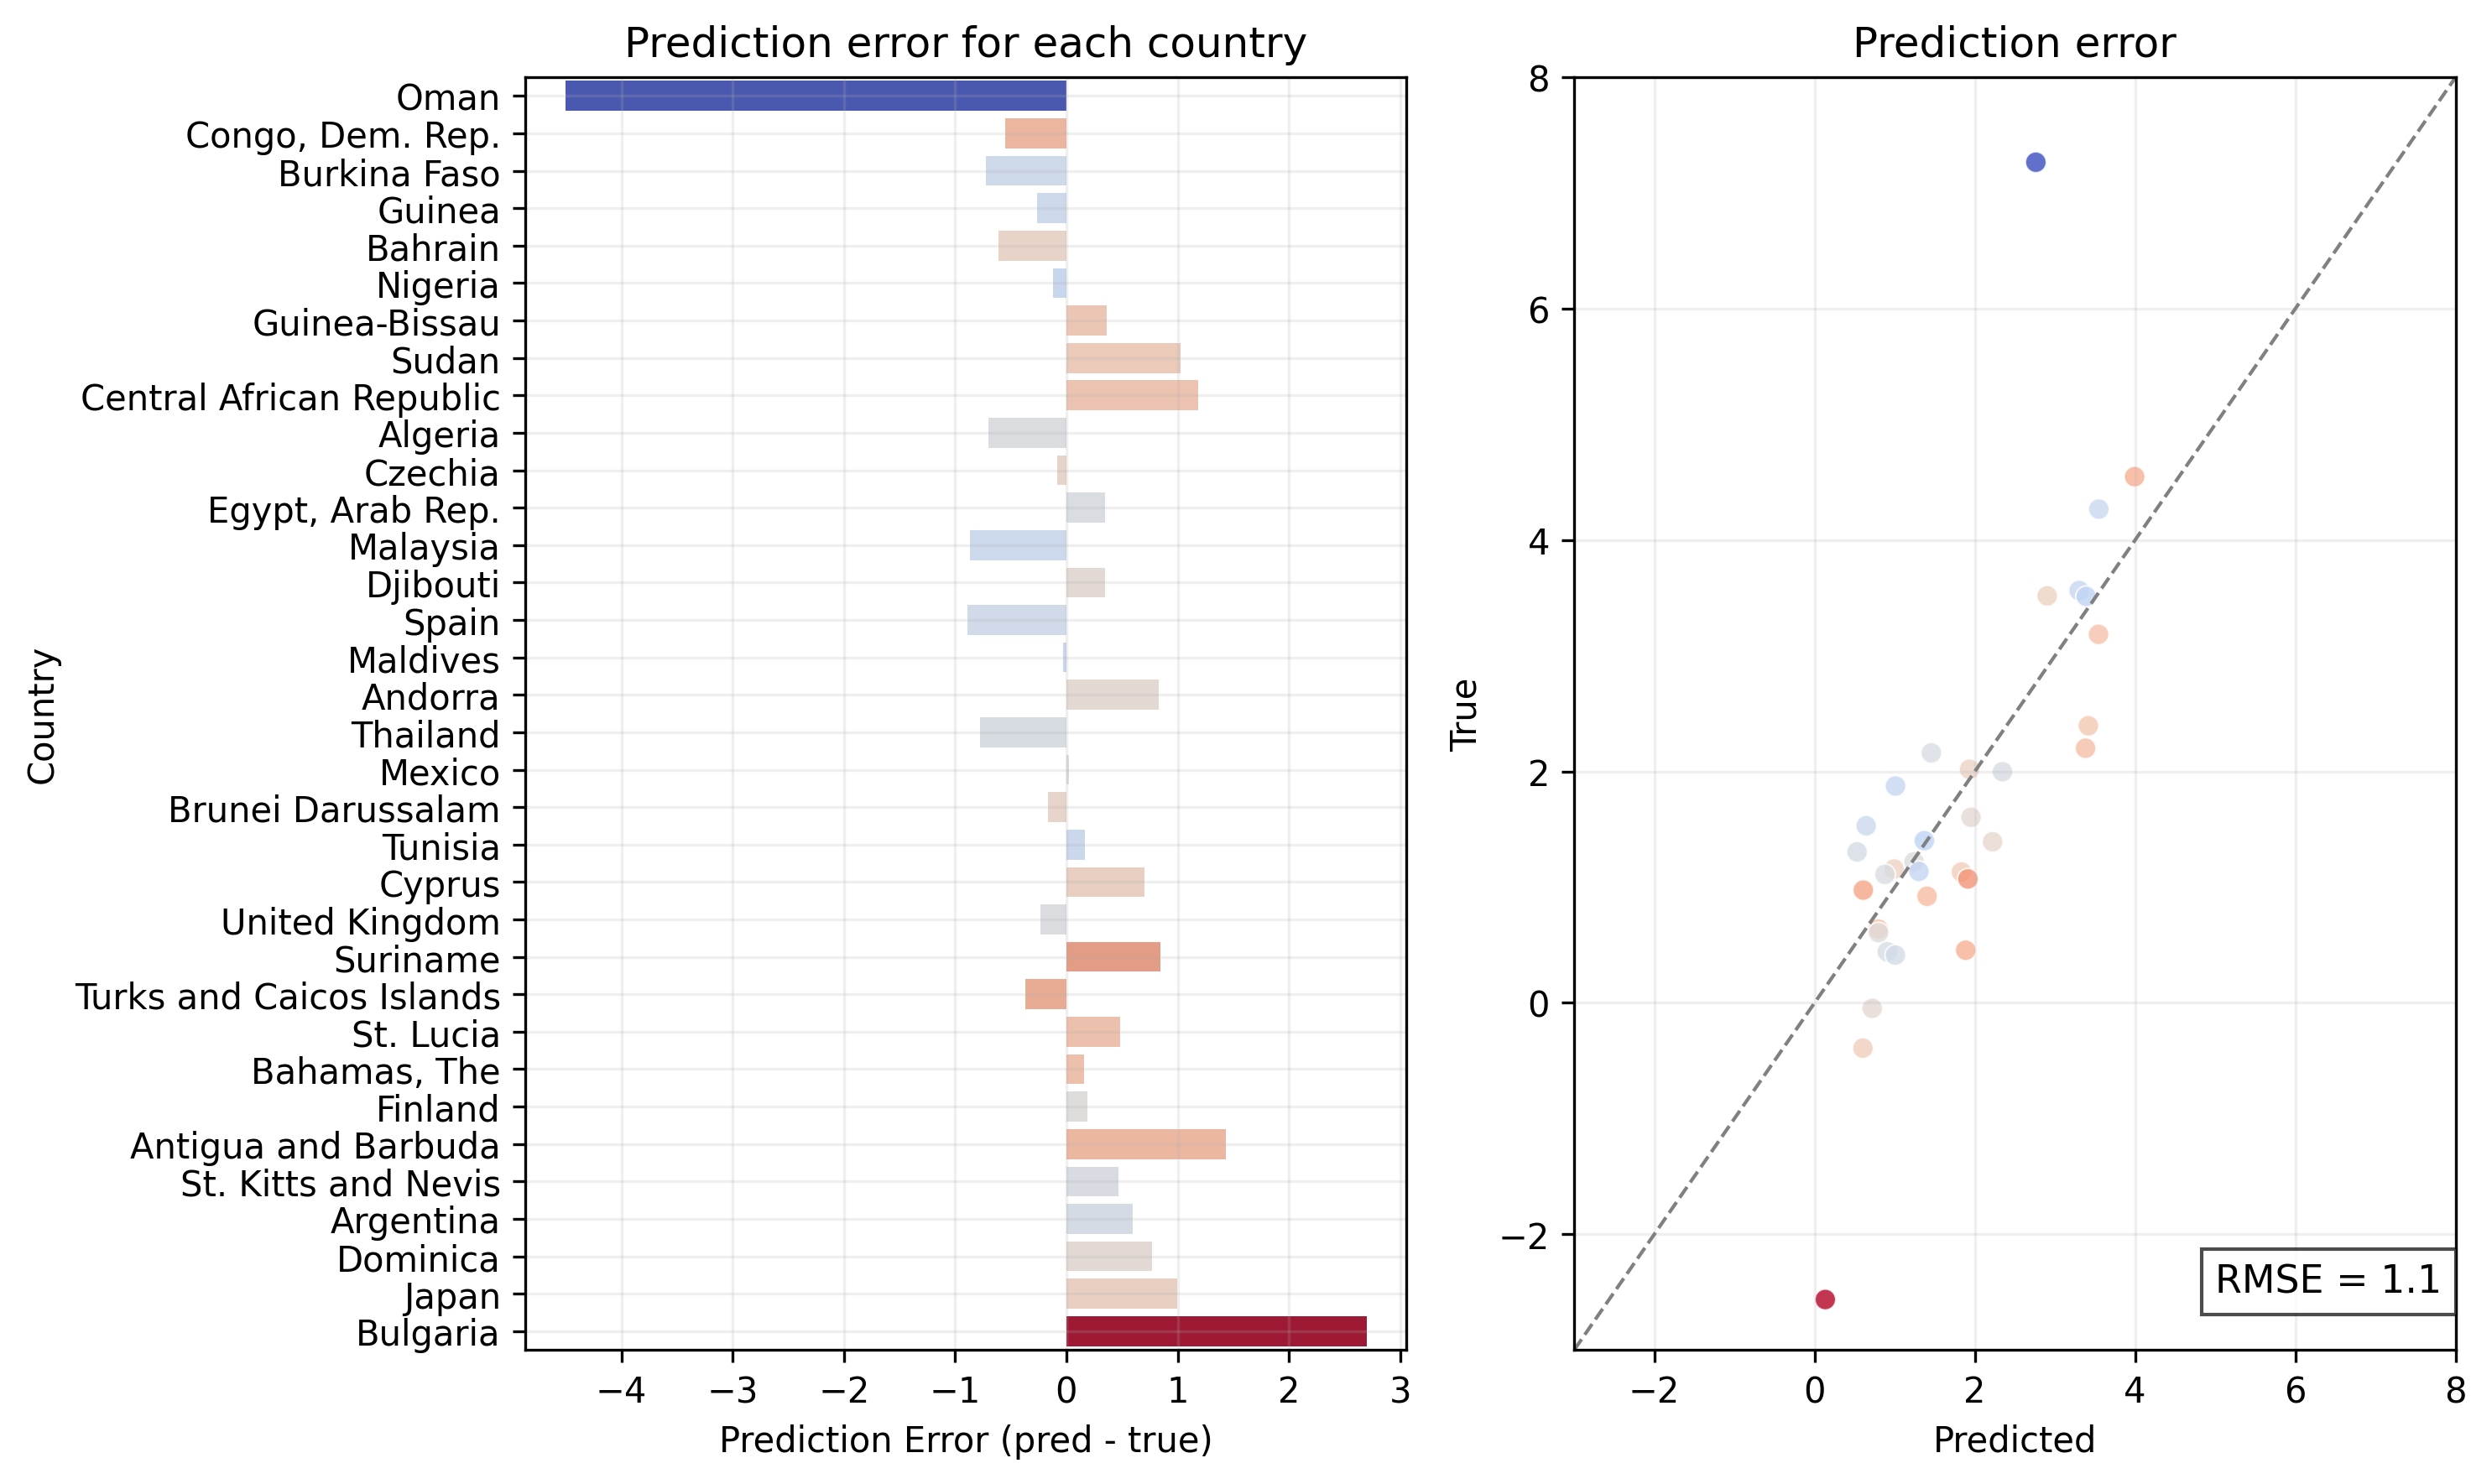

In [23]:
pred_test = pd.Series(final_model.predict(X_test))

# reset indexes 
pred_test_results = pd.DataFrame({
    "pred": pred_test.reset_index(drop=True),
    "true": y_test.reset_index(drop=True), 
    "diff": pred_test.reset_index(drop=True) - y_test.reset_index(drop=True),
    "Country": c_test["country"].reset_index(drop=True)
})

pred_test_results = pred_test_results.sort_values(by="true", ascending=False)

# Define colormap and ensure 0 is the midpoint
cmap = sns.color_palette("coolwarm", as_cmap=True)
norm = mcolors.TwoSlopeNorm(vmin=pred_test_results["diff"].min(), 
                            vcenter=0, 
                            vmax=pred_test_results["diff"].max())
colors = [cmap(norm(value)) for value in pred_test_results["diff"]]

rmse_str = f"RMSE = {np.round(final_results["Test_rmse"][0], 2)}"

fig, axs = plt.subplots(ncols=2, sharey=False, figsize=(10, 6), dpi=300)
sns.barplot(data=pred_test_results, y="Country", x="diff", hue="diff", palette=colors, legend=False, ax=axs[0])
axs[0].grid(alpha=0.2)
axs[0].set_xlabel("Prediction Error (pred - true)")
axs[0].set_ylabel("Country")
axs[0].set_title("Prediction error for each country")

sns.scatterplot(pred_test_results, y = "true", x="pred", hue= "diff", alpha =0.8,  palette = colors, legend=False, ax=axs[1])
axs[1].grid(alpha=0.2)
axs[1].plot([-3, 8], [-3, 8], color="grey", linestyle="--", linewidth=1)  
axs[1].text(5, -2.5, rmse_str, fontsize=11, bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))
axs[1].set_xlabel("Predicted")
axs[1].set_ylabel("True")
axs[1].set_xlim(-3,8)
axs[1].set_ylim(-3,8)
axs[1].set_title("Prediction error")

fig.tight_layout()

fig.savefig("img/PredictionResults.png", dpi=300, bbox_inches='tight')
fig.show()

## What factors contribute the most to urban population growth?
### Examine feature importance of prediction model

In [24]:
# get feature importance and sort
features_without_y = [f for f in features if f != "Urban population growth (annual %)"]


feat_imp = pd.DataFrame({
    "features": features_without_y,
    "importance": final_model.feature_importances_
    })

feat_imp = feat_imp.sort_values(by="importance", ascending=False)

print(feat_imp)

                                             features  importance
8                  Rural population growth (annual %)    0.391921
1   Age dependency ratio, young (% of working-age ...    0.267166
0   Age dependency ratio, old (% of working-age po...    0.203507
10     Secure Internet servers (per 1 million people)    0.058264
7            Urban population (% of total population)    0.021538
11                   GDP per capita growth (annual %)    0.013319
3                        Merchandise trade (% of GDP)    0.012890
2              Compulsory education, duration (years)    0.012505
4                                       Net migration    0.011896
5              Preprimary education, duration (years)    0.003516
9               Secondary education, duration (years)    0.002172
6                 Primary education, duration (years)    0.001306


### Use Shapley values to dive deeper into feature analyses

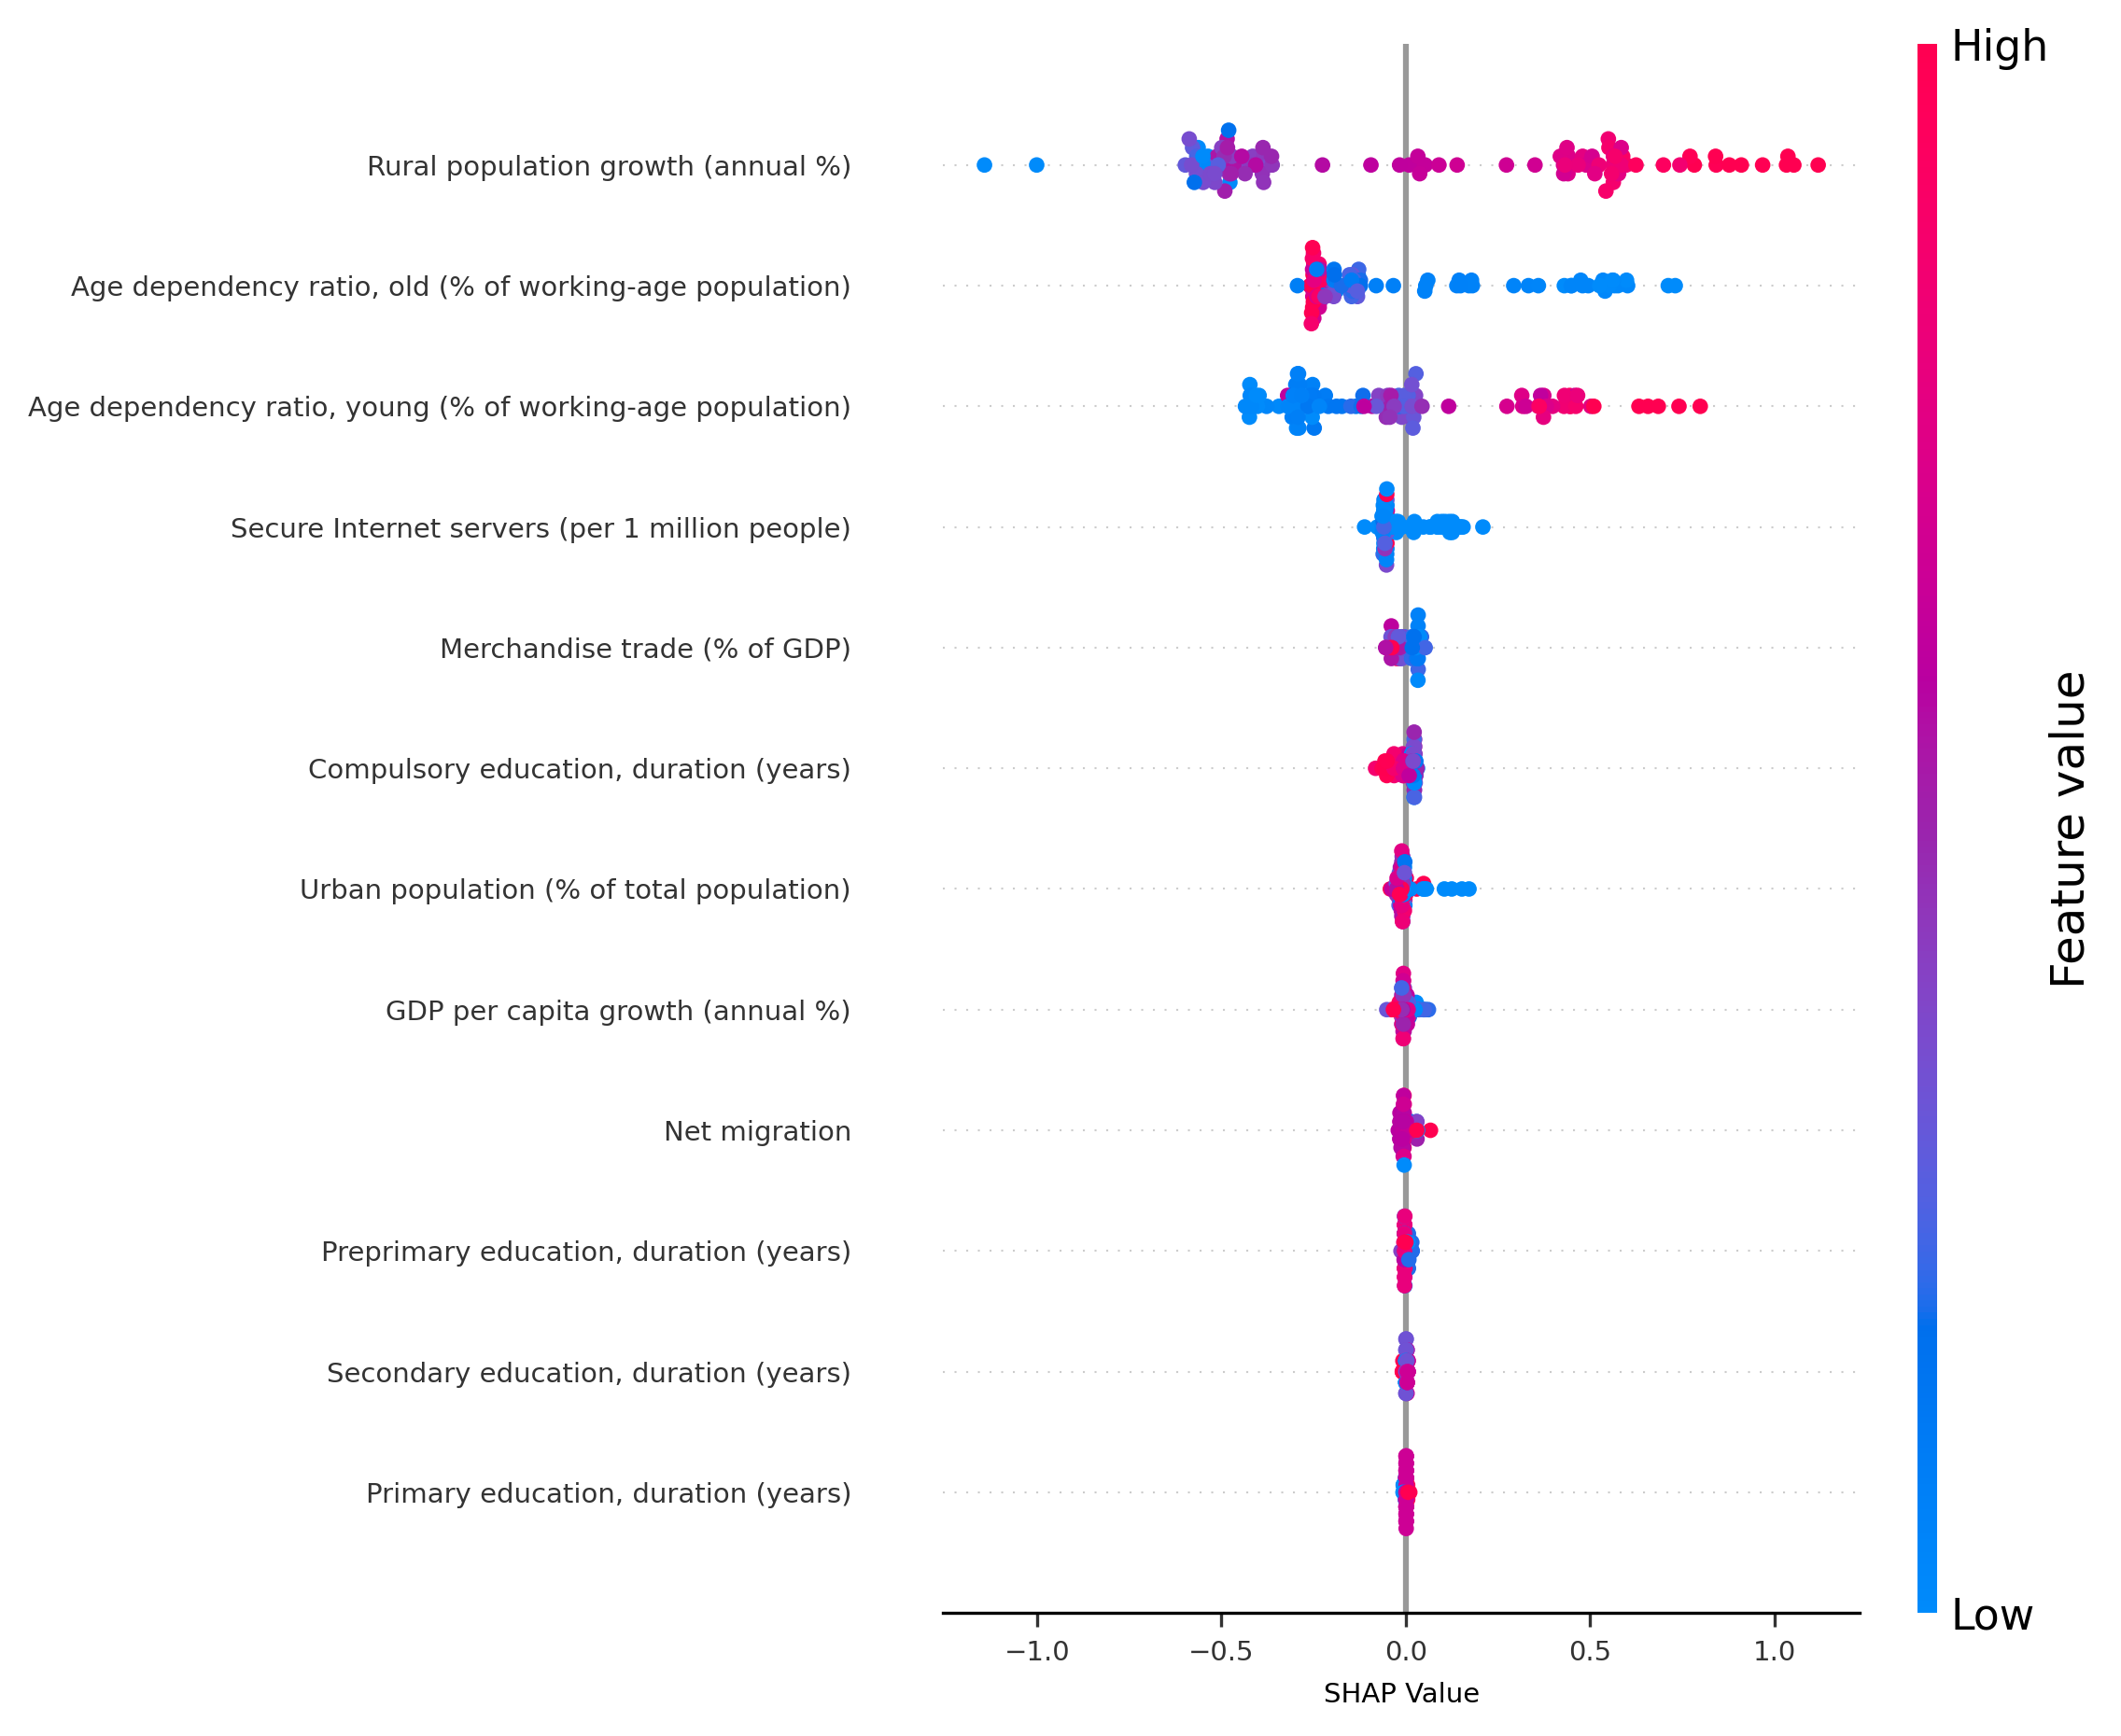

In [25]:
# evaluate feature importance of selected model with shapley values
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_train)


# SHAP summary plot (dot plot)

plt.figure(figsize=(10, 4), dpi=300)
shap.summary_plot(shap_values, X_train, show=False)

plt.tick_params(axis='x', labelsize=7)
plt.tick_params(axis='y', labelsize=7)
plt.xlabel("SHAP Value", fontsize=7)
plt.ylabel("", fontsize=7)

# Adjust layout and save
plt.tight_layout()
plt.savefig('img/shapValue_plot.png', dpi=300)
plt.show()

## What separates the 10 countries with the highest urban growth from the 10 countries with the lowest urban growth? 


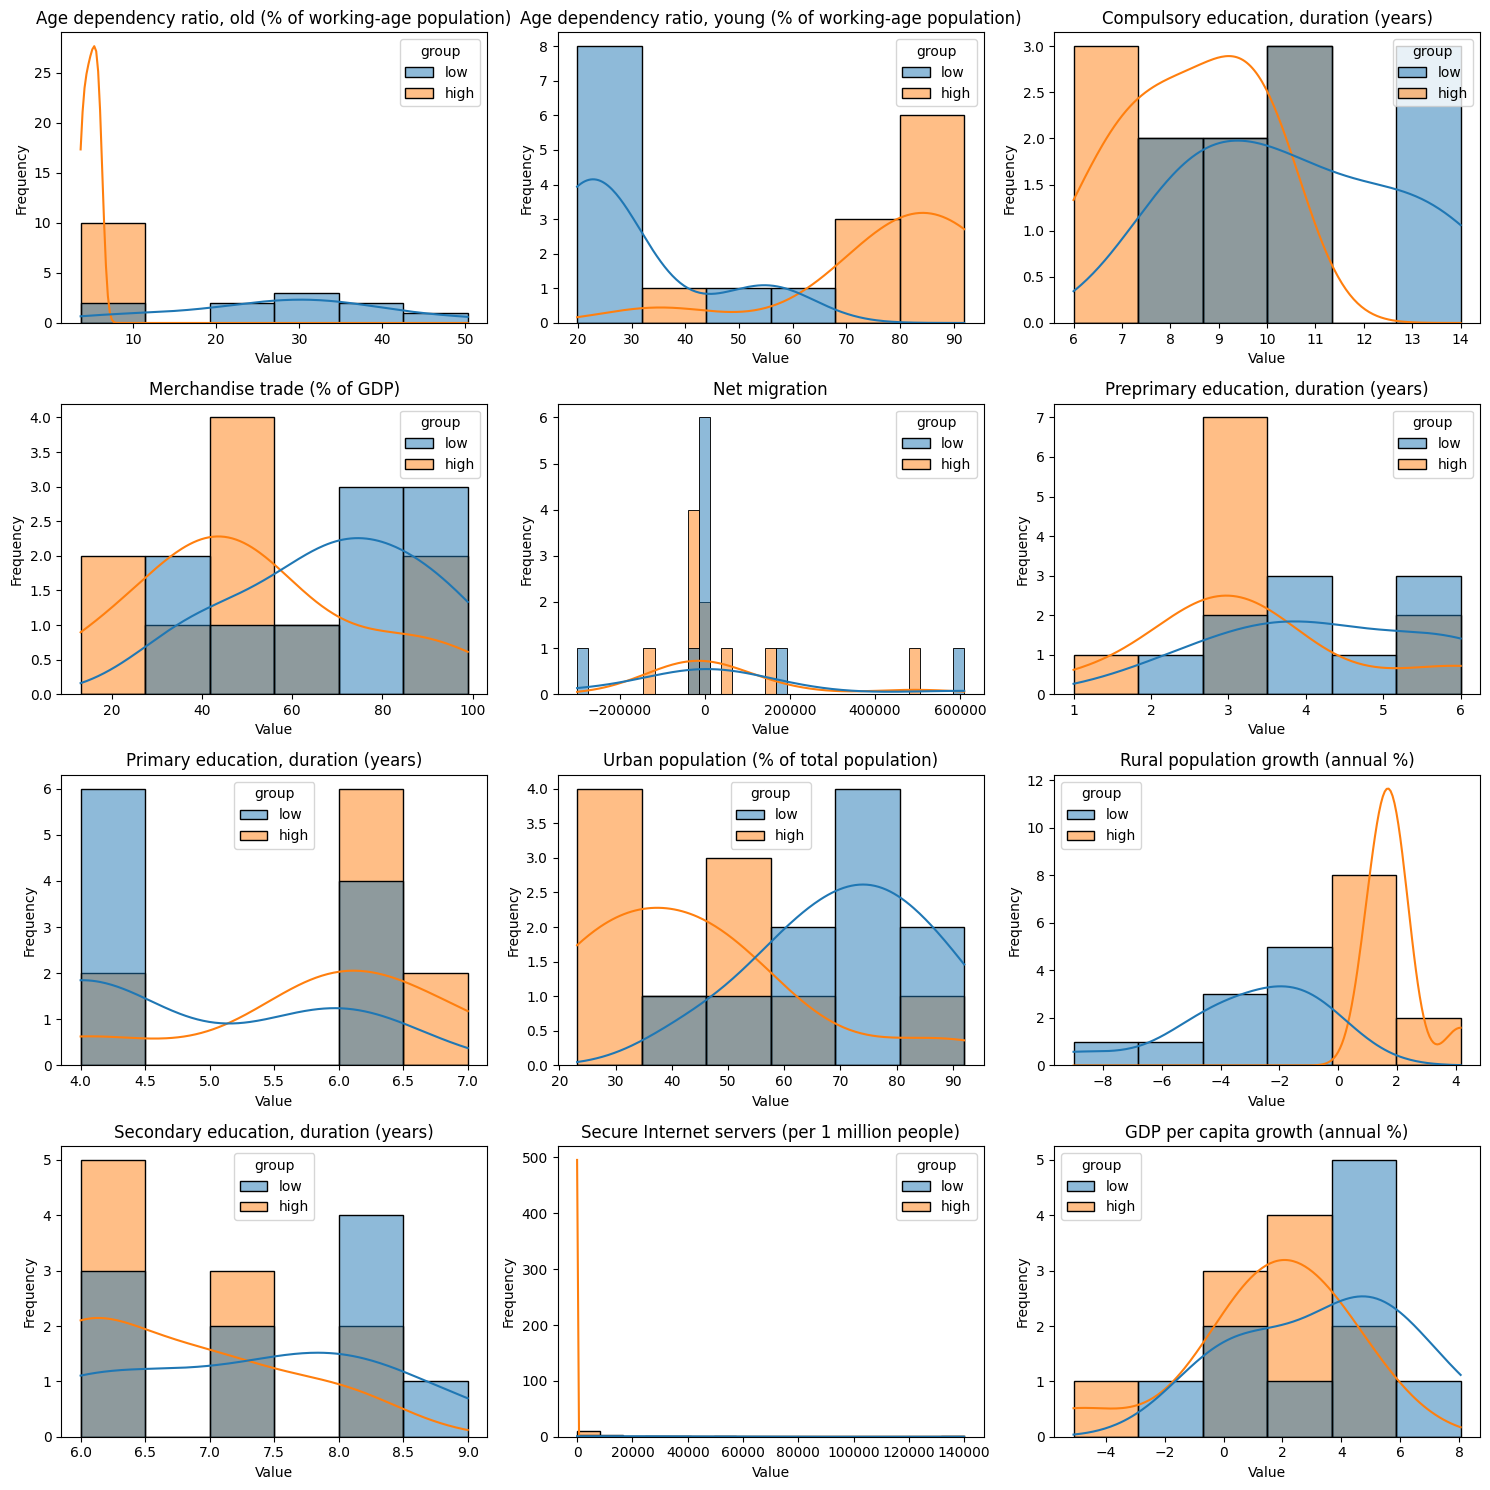

In [26]:
# Distribution plot of each feature color-coded by top10 vs. low10 countries

data["country"] = countries["country"]
data_sorted = data.sort_values(by="Urban population growth (annual %)")

# concatenate first 10 and last 10 entries
df20 = pd.concat([data_sorted.head(n=10), data_sorted.tail(n=10)], ignore_index=True)
df20["group"] = pd.Series(["low"] * 10 + ["high"] * 10)


# Plot the histograms
fig, axs = plt.subplots(4, 3, figsize=(15, 15))
axs = axs.flatten()

# Plot each column
for i, column in enumerate(df20.columns.drop(labels=["Urban population growth (annual %)", "country", "group"])):
    sns.histplot(data=df20, x=column, kde=True, hue="group", ax=axs[i])
    axs[i].set_title(f"{column}")
    axs[i].set_xlabel("Value")
    axs[i].set_ylabel("Frequency")

# remove empty subplot
for j in range(len(data.columns), len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.savefig('img/featureHistograms_HighLow.png', dpi=300, bbox_inches='tight')
plt.show()



## How can we use this knowledge for future urban planning?
### Prediction for a hypothetical country




In [27]:
# simulated country for a mock prediction
sim_country = pd.DataFrame({
    'Age dependency ratio, old (% of working-age population)': [3], 
    'Age dependency ratio, young (% of working-age population)': [50], 
    'Compulsory education, duration (years)':[14],
    'Merchandise trade (% of GDP)': [50],
    'Net migration': [-1000],
    'Preprimary education, duration (years)': [3], 
    'Primary education, duration (years)': [4], 
    'Urban population (% of total population)': [90], 
    'Rural population growth (annual %)': [-5], 
    'Secondary education, duration (years)': [7], 
    'Secure Internet servers (per 1 million people)': [21791],
    'GDP per capita growth (annual %)': [3],
})



# predict simulate country
sim_res = final_model.predict(sim_country)
print("Urban population growth for simulated data {:.2f} %".format(sim_res.item()))



Urban population growth for simulated data 1.10 %
